In [1]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
LEARNING_RATE = 0.01
IN_FEATURES = 124
OUT_FEATURES = 128
RANDOM_SEED = 42
BATCH_SIZE = 32
hidden_dim = 10

In [4]:
# use validation year: change path
X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
y=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

# # use all 8 years: change path
# X_train=np.load('/work/sds-lab/Shuochen/climsim/train_input.npy')
# y_train=np.load('/work/sds-lab/Shuochen/climsim/train_target.npy')
# X_test=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
# y_test=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')

# X_train = torch.from_numpy(X_train).type(torch.float).to(device)
# y_train = torch.from_numpy(y_train).type(torch.float).to(device)
# X_test = torch.from_numpy(X_test).type(torch.float).to(device)
# y_test = torch.from_numpy(y_test).type(torch.float).to(device)

# add channel shape
X = X.unsqueeze(1)
y = y.unsqueeze(1)

# split datasets to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# create datasets
training_set = TensorDataset(X_train, y_train)
testing_set = TensorDataset(X_test, y_test)
# create dataloaders
train_dataloader = DataLoader(training_set, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)
test_dataloader = DataLoader(testing_set,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [5]:
X.shape

torch.Size([1441920, 1, 124])

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_block1 = nn.Sequential(nn.Conv1d(1, 6, 3, 1, 0),
                                    nn.ReLU(),
                                    nn.Dropout(0.175),
                                    nn.Conv1d(6, 6, 3, 1, 0),
                                    nn.ReLU(),
                                    nn.Dropout(0.175),
                                    nn.MaxPool1d(2, 1, 0))
        
        # self.cnn_block2 = nn.Sequential(nn.Conv1d(6, 6, 3, 1, 0),
        #                             nn.ReLU(),
        #                             nn.Conv1d(6, 16, 3, 1, 0),
        #                             nn.ReLU(),
        #                             nn.MaxPool1d(2, 1, 0))
        
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(714, 32),
                                    nn.Linear(32, 128))
        
    def forward(self, x):
        x = self.linear(self.cnn_block1(x))
        x = x.unsqueeze(1)
        return x
        

model_0 = CNN().to(device)

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-4)

In [8]:
torch.manual_seed(42)
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    with torch.inference_mode():
        test_loss = 0
        model_0.eval()
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}\n------")

Epoch: 0
Train loss: 0.00846 | Test loss: 0.00660
------
Epoch: 1
Train loss: 0.00651 | Test loss: 0.00642
------
Epoch: 2
Train loss: 0.00636 | Test loss: 0.00631
------


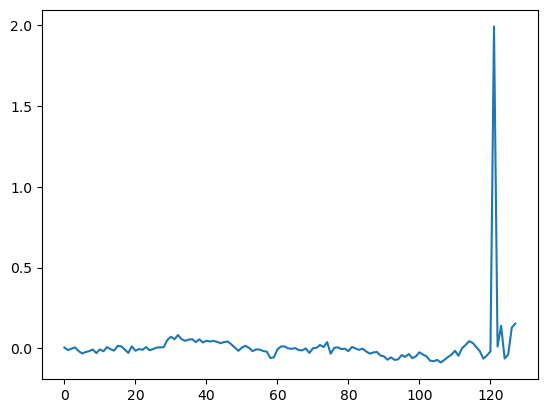

In [9]:
plt.plot(test_pred.cpu().detach().numpy()[0,0,:])